<a href="https://colab.research.google.com/github/hhboorstein/ds_portfolio/blob/main/DSBA_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mobile Market 

## Problem Statement

### Objective

Mobile Market is a retailer leveraging machine learning to profit in the growing secondary market for mobile devices. Our goal is to analyze their supplied data and lend insights&mdash;such as factors that influence price&mdash;through a linear model.

Data from 2021 contains the following features:

- brand_name
- os: operating system
- screen_size: screen size in cm diag.
- 4g: 4G capability
- 5g: 5G capability
- main_camera_mp: Resolution of the rear camera in megapixels
- selfie_camera_mp: Resolution of the front camera in megapixels
- int_memory: internal memory (ROM) in GB
- ram: RAM in GB
- battery: battery capacity (mAh)
- weight: device weight (grams)
- release_year
- days_used: Number of days the used/refurbished device has been used
- normalized_new_price: Normalized price of a new device of the same model in euros
- normalized_used_price: Normalized price of the used/refurbished device in euros

## Importing necessary libraries

In [ ]:
# math and data
import numpy as np
import scipy.stats as stats
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to split the data set
from sklearn.model_selection import train_test_split

# to build the linear model
import statsmodels
import statsmodels.api as sm

## Loading the dataset

In [ ]:
phone=pd.read_csv('used_device_data.csv')

In [ ]:
phone_copy=phone.copy()

## Data Overview

In [ ]:
phone.shape

(3454, 15)

In [ ]:
phone.head()

,brand_name,os,screen_size,4g,5g,main_camera_mp,selfie_camera_mp,int_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837


This is a sizable data set: 15 columns with over 3400 entries! I'm curious whether OS will end up being a significant factor, as I'd guess brand would be more important. Additionally, the normalized prices both seem shockingly low. I'll need to follow up with the histogram or boxplot later.

In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand_name             3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   main_camera_mp         3275 non-null   float64
 6   selfie_camera_mp       3452 non-null   float64
 7   int_memory             3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

A first inspection shows the data types all appear to be correct. From the head, we can see that 4g and 5g are recorded as 'yes' or 'no', so it follows that these columns would be objects.

In [ ]:
phone.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

We do have some null entries, most notably in the main_camera_mp column, with 179 null entries. That being said, it does only make up around 5% of the data. The other columns with null entries are: selfie_camera_mp, int_memory, ram, battery, and weight.

There is a possibility that brand_name or os have missing data as '?' or 'unknown', so let's check for that too.

In [ ]:
phone['brand_name'].value_counts()

Others        502
Samsung       341
Huawei        251
LG            201
Lenovo        171
ZTE           140
Xiaomi        132
Oppo          129
Asus          122
Alcatel       121
Micromax      117
Vivo          117
Honor         116
HTC           110
Nokia         106
Motorola      106
Sony           86
Meizu          62
Gionee         56
Acer           51
XOLO           49
Panasonic      47
Realme         41
Apple          39
Lava           36
Celkon         33
Spice          30
Karbonn        29
Coolpad        22
BlackBerry     22
Microsoft      22
OnePlus        22
Google         15
Infinix        10
Name: brand_name, dtype: int64

There's a catchall 'Others' group. This is missing data and may mess up our model; there is presumably more than one brand categorized as other. We will review this during the model tuning.

In [ ]:
phone['os'].value_counts()

Android    3214
Others      137
Windows      67
iOS          36
Name: os, dtype: int64

There is also an 'Others' label here. Again, we may need to remove these to create a powerful model.

In [ ]:
phone.duplicated().sum()

0

There are no duplicate rows.

## Exploratory Data Analysis (EDA)

In [ ]:
phone.describe().T

,count,mean,std,min,25%,50%,75%,max
screen_size,3454.0,13.713115,3.805280,5.080000,12.700000,12.830000,15.340000,30.710000
main_camera_mp,3275.0,9.460208,4.815461,0.080000,5.000000,8.000000,13.000000,48.000000
selfie_camera_mp,3452.0,6.554229,6.970372,0.000000,2.000000,5.000000,8.000000,32.000000
int_memory,3450.0,54.573099,84.972371,0.010000,16.000000,32.000000,64.000000,1024.000000
ram,3450.0,4.036122,1.365105,0.020000,4.000000,4.000000,4.000000,12.000000
battery,3448.0,3133.402697,1299.682844,500.000000,2100.000000,3000.000000,4000.000000,9720.000000
weight,3447.0,182.751871,88.413228,69.000000,142.000000,160.000000,185.000000,855.000000
release_year,3454.0,2015.965258,2.298455,2013.000000,2014.000000,2015.500000,2018.000000,2020.000000
days_used,3454.0,674.869716,248.580166,91.000000,533.500000,690.500000,868.750000,1094.000000
normalized_used_price,3454.0,4.364712,0.588914,1.536867,4.033931,4.405133,4.755700,6.619433


Let's start with some highlights of the statistical summary.
* Mean screen size is 13.7cm, or about 5.4in.
* The median resolution of the main camera is 8MP, although the largest one avaiable has 48MP!
* The resolution of the selfie camera is generally lower than that of the main camera.
* The middle 50% of the data for internal memory falls between 16GB and 64GB.
* While device weight is generally less than 200g, the max observation is 855g, indicating the strong possibility of at least one outlier.
* Days used is highly variable.
* Both used price and new price are lower than I would expect, although new price is predictably higher than used.



In [ ]:
phone.describe(include='object').T

,count,unique,top,freq
brand_name,3454,34,Others,502
os,3454,4,Android,3214
4g,3454,2,yes,2335
5g,3454,2,no,3302


For the non-numeric columns, there are 34 brands, though the catchall 'Other' category is most common. Android is the OS with the overwhelming majority of devices on Mobile Market, and 4G connectivity is far more common than 5G.

In [ ]:
sns.set_theme()

We'll start with a first glance at each of our columns.

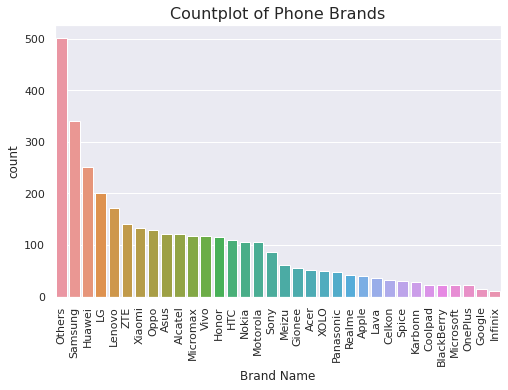

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Countplot of Phone Brands',fontsize=16)
sns.countplot(data=phone,
              x='brand_name',
              order=phone['brand_name'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Brand Name');

Aside from the 'Others' designation, Samsung is the most common brand in the Mobile Market system, followed by Huawei, LG, and Lenovo. OnePlus, Google, and Infinix are the least common brands.

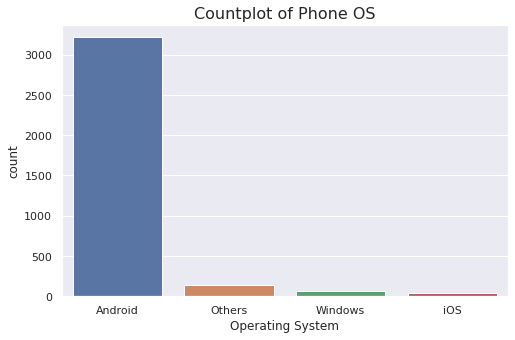

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Countplot of Phone OS',fontsize=16)
sns.countplot(data=phone,
              x='os',
              order=phone['os'].value_counts().index)
plt.xlabel('Operating System');

In [ ]:
phone['os'].value_counts(normalize=True)

Android    0.930515
Others     0.039664
Windows    0.019398
iOS        0.010423
Name: os, dtype: float64

Android is far and away the most popular phone OS in the Mobile Market system. It is installed on 93% of the phones.

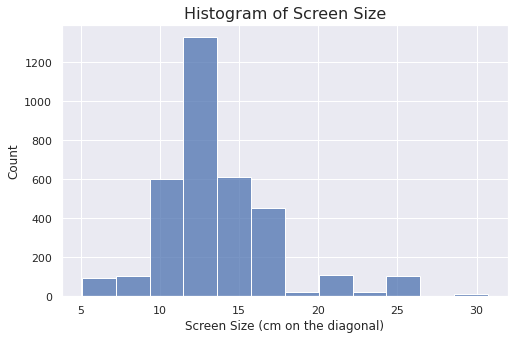

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Histogram of Screen Size',fontsize=16)
sns.histplot(data=phone,x='screen_size',bins=12)
plt.xlabel('Screen Size (cm on the diagonal)');

The most common sceen size is around 12.5cm on the diagonal (about 5in). It looks like the most popular screen sizes fall between 10cm and 18cm. There are some devices on Mobile Market with screens greater than 20cm; there are roughly as many of these as there are devices with screens less than 10cm.

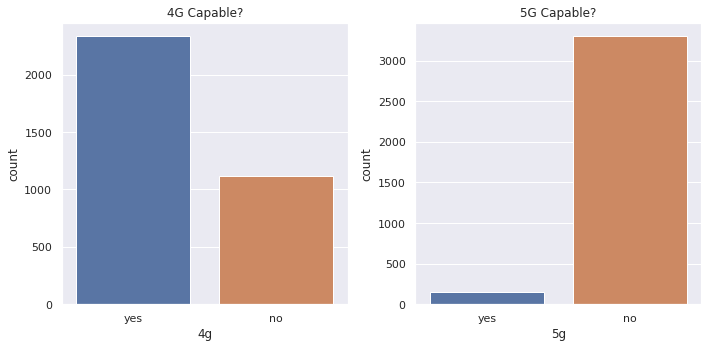

In [ ]:
plt.figure(figsize=(10,5))

# 4g
plt.subplot(1,2,1)
plt.title('4G Capable?')
sns.countplot(data=phone,x='4g',order=('yes','no'))

# 5g
plt.subplot(1,2,2)
plt.title('5G Capable?')
sns.countplot(data=phone,x='5g',order=('yes','no'))

plt.tight_layout()

While roughly two-thirds of phones on Mobile Market have 4G capability, very few have 5G.

In [ ]:
# import numeric data type check from pandas
from pandas.api.types import is_numeric_dtype

def hist_box(df,col,*,kde=False):
  '''Plot a histogram and boxplot 
  of numeric column in data frame.
  Optional KDE boolean.'''

  # include only numeric cols
  if is_numeric_dtype(df[col])==False:
    raise TypeError('Column must be numeric.')
  
  # figure setup
  plt.figure(figsize=(12,5))

  # histogram
  plt.subplot(1,2,1)
  plt.title('Histogram of '+str(col),fontsize=14)
  sns.histplot(data=df,x=col,kde=kde)

  # boxplot
  plt.subplot(1,2,2)
  plt.title('Boxplot of '+str(col),fontsize=14)
  sns.boxplot(data=df,x=col)

  # display figure
  plt.tight_layout()
  return

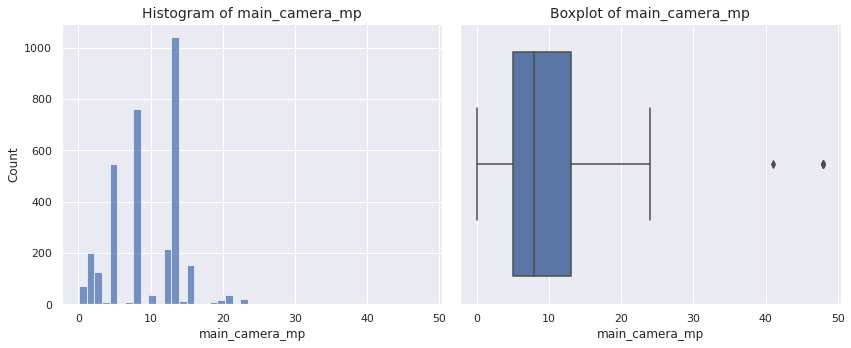

In [ ]:
hist_box(phone,'main_camera_mp')

The distribution of main camera resolution is sporatic, but 75% of the data is concentrated below 15MP.

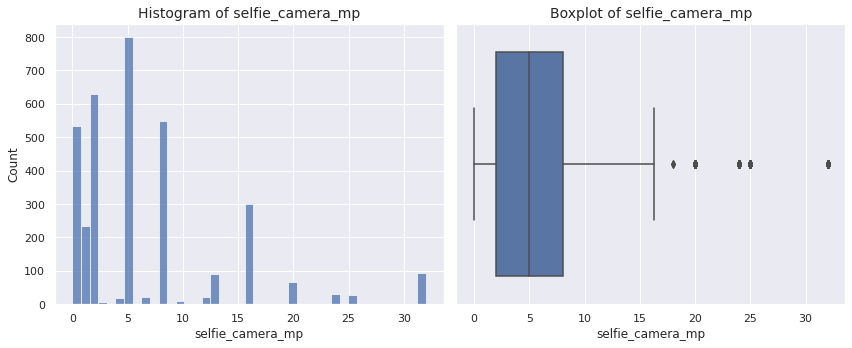

In [ ]:
hist_box(phone,'selfie_camera_mp')

The histogram of selfie camera resolution would lead one to believe these observations are more spread out than those for the main camera, but the boxplot shows that the data is still concentrated on the lower end. There are just more outliers in these observations that skew the data.

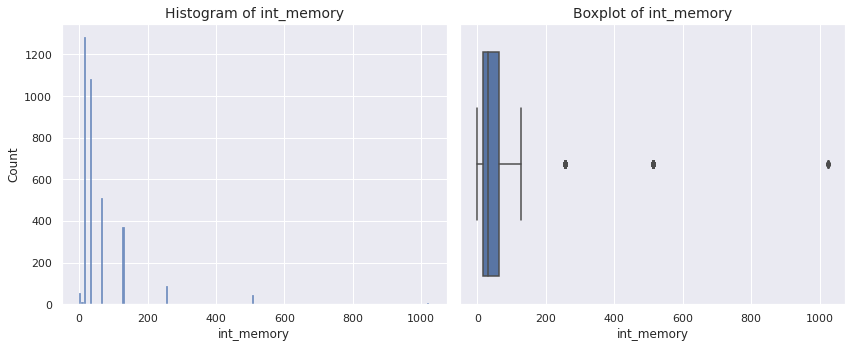

In [ ]:
hist_box(phone,'int_memory')

Internal memory is heavily skewed by outliers, so let's visualize the data without the outliers.

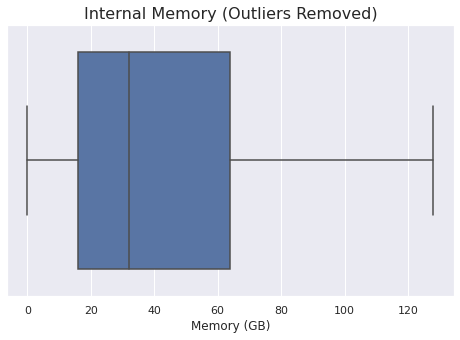

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Internal Memory (Outliers Removed)',fontsize=16)
sns.boxplot(data=phone,x='int_memory',showfliers=False)
plt.xlabel('Memory (GB)');

Now we can see that almost all phones on Mobile Market have between 0 and 130GB of internal storage. The data is still looks right-skewed, as the lower 50% is narrower than the upper 50%. However most memory comes in powers of 2, so we can see that the 25, 50, and 75 quartiles are 16GB, 32GB, and 64GB respectively. In other words, internal memory data is not continuous, so the skewed appearance of the data is likely misleading.

In [ ]:
two_powers=[float(2**i) for i in range(12)]
mem_counts=phone['int_memory'].value_counts(normalize=True)
percent=0
for idx in mem_counts.index:
  if idx in two_powers:
    percent+=mem_counts[idx]
print(percent)

0.9875362318840579


In fact, a quick calculation shows that almost all (98.75%) internal memory comes as a power of 2.

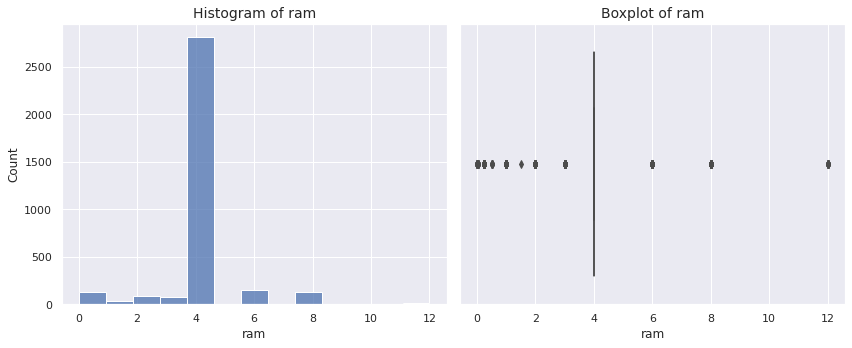

In [ ]:
hist_box(phone,'ram')

In [ ]:
phone['ram'].value_counts(normalize=True)

4.00     0.815942
6.00     0.044638
8.00     0.037681
2.00     0.026087
0.25     0.024058
3.00     0.023478
1.00     0.009855
12.00    0.005217
0.02     0.005217
0.03     0.004928
0.50     0.002609
1.50     0.000290
Name: ram, dtype: float64

We find that 81.6% of phones on Mobile Market have 4GB of RAM. Other common options are 2GB, 6GB, and 8GB.

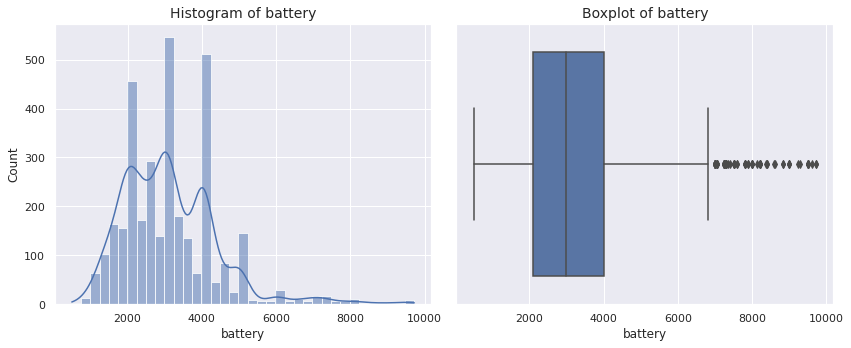

In [ ]:
hist_box(phone,'battery',kde=True)

The battery data is concentrated between roughly 1500mAh and 5000mAh, with three peaks in between. Battery capacity is right skewed with many outliers.

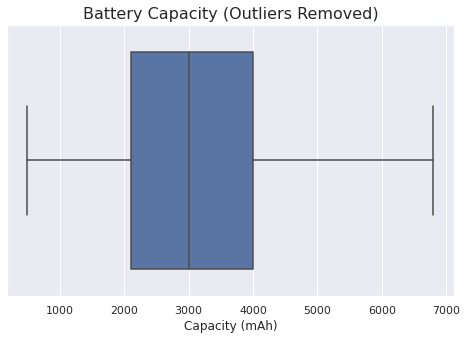

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Battery Capacity (Outliers Removed)',fontsize=16)
sns.boxplot(data=phone,x='battery',showfliers=False)
plt.xlabel('Capacity (mAh)');

Without the outliers, battery capacity looks more evenly distributed. The median capacity is around 3000mAh, with the middle 50% concentrated between 2000mAh and 4000mAh.

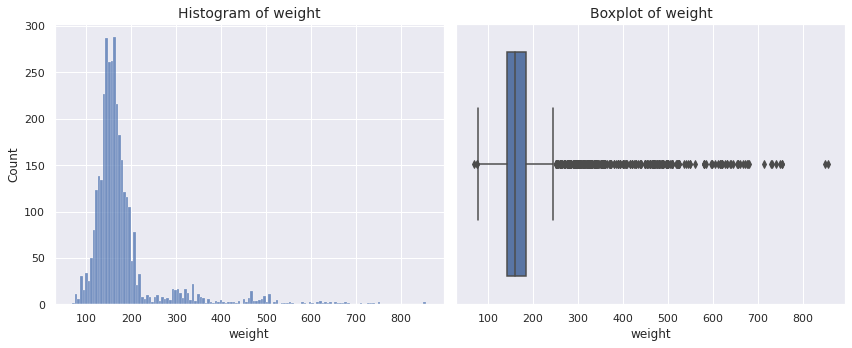

In [ ]:
hist_box(phone,'weight')

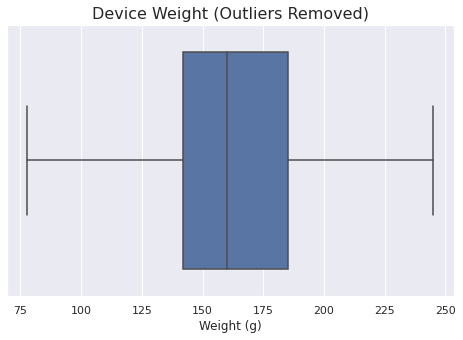

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Device Weight (Outliers Removed)',fontsize=16)
sns.boxplot(data=phone,x='weight',showfliers=False)
plt.xlabel('Weight (g)');

While device weight is generally concentrated between 75g and 250g, there are too many outliers to throw them all away. In particular, there's a real possibility these outliers will have an effect on our model. 

In [ ]:
phone['release_year'].unique()

array([2020, 2019, 2013, 2014, 2016, 2018, 2015, 2017])

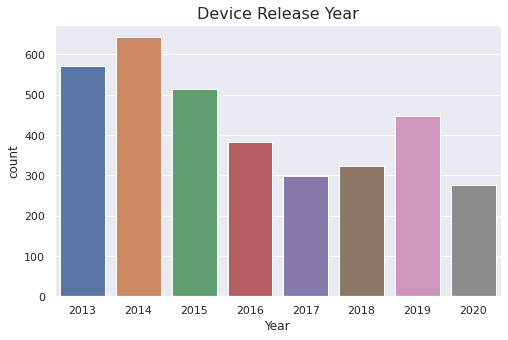

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Device Release Year',fontsize=16)
sns.countplot(data=phone,x='release_year')
plt.xlabel('Year');

The most common release year is 2014, followed by 2013 and 2015. There's a dip in popularity after 2015, with 2019 being the exception.

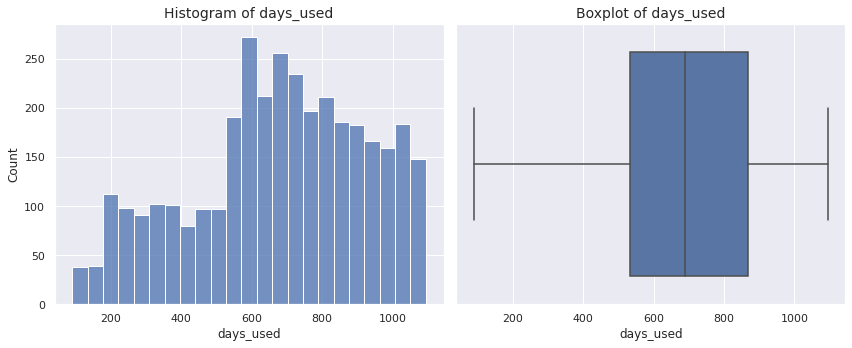

In [ ]:
hist_box(phone,'days_used')

Days used is fairly evenly distributed, with a vague peak around 600 days.

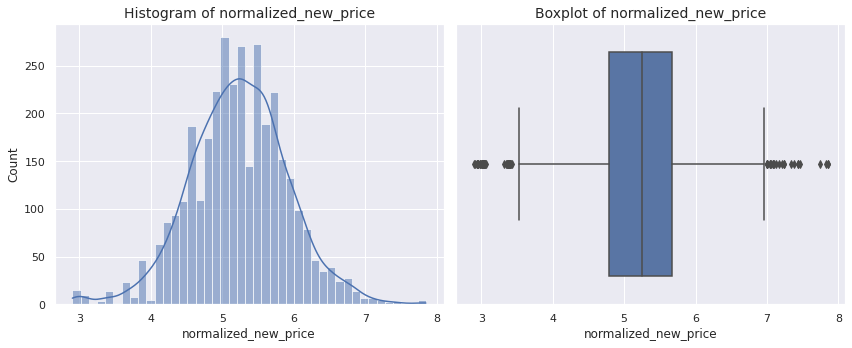

In [ ]:
hist_box(phone,'normalized_new_price',kde=True)

Normalized new price is approximately normally distributed with long tails on both sides. The peak is around 5€. The boxplot shows that there are many outliers.

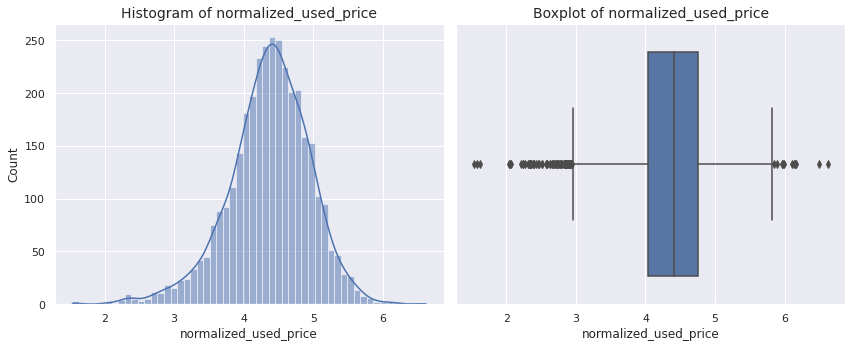

In [ ]:
hist_box(phone,'normalized_used_price',kde=True)

Used price is disributed smoothly between 2€ and 6€ with a slight left skew. The peak is around 4.25€ and there are many outliers in the boxplot.

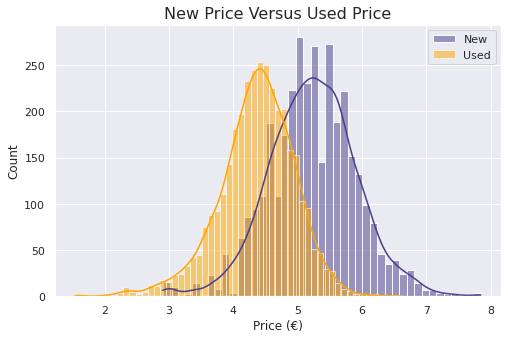

In [ ]:
# comparison of new price and used price
plt.figure(figsize=(8,5))
plt.title('New Price Versus Used Price',fontsize=16)
sns.histplot(data=phone,x='normalized_new_price',
             color='darkslateblue',label='New',kde=True)
sns.histplot(data=phone,x='normalized_used_price',
             color='orange',label='Used',kde=True)
plt.legend()
plt.xlabel('Price (€)');

Here is a direct comparison of new and used prices. We see that new prices generally trend higher.

Next, let's look at how RAM varies by brand.

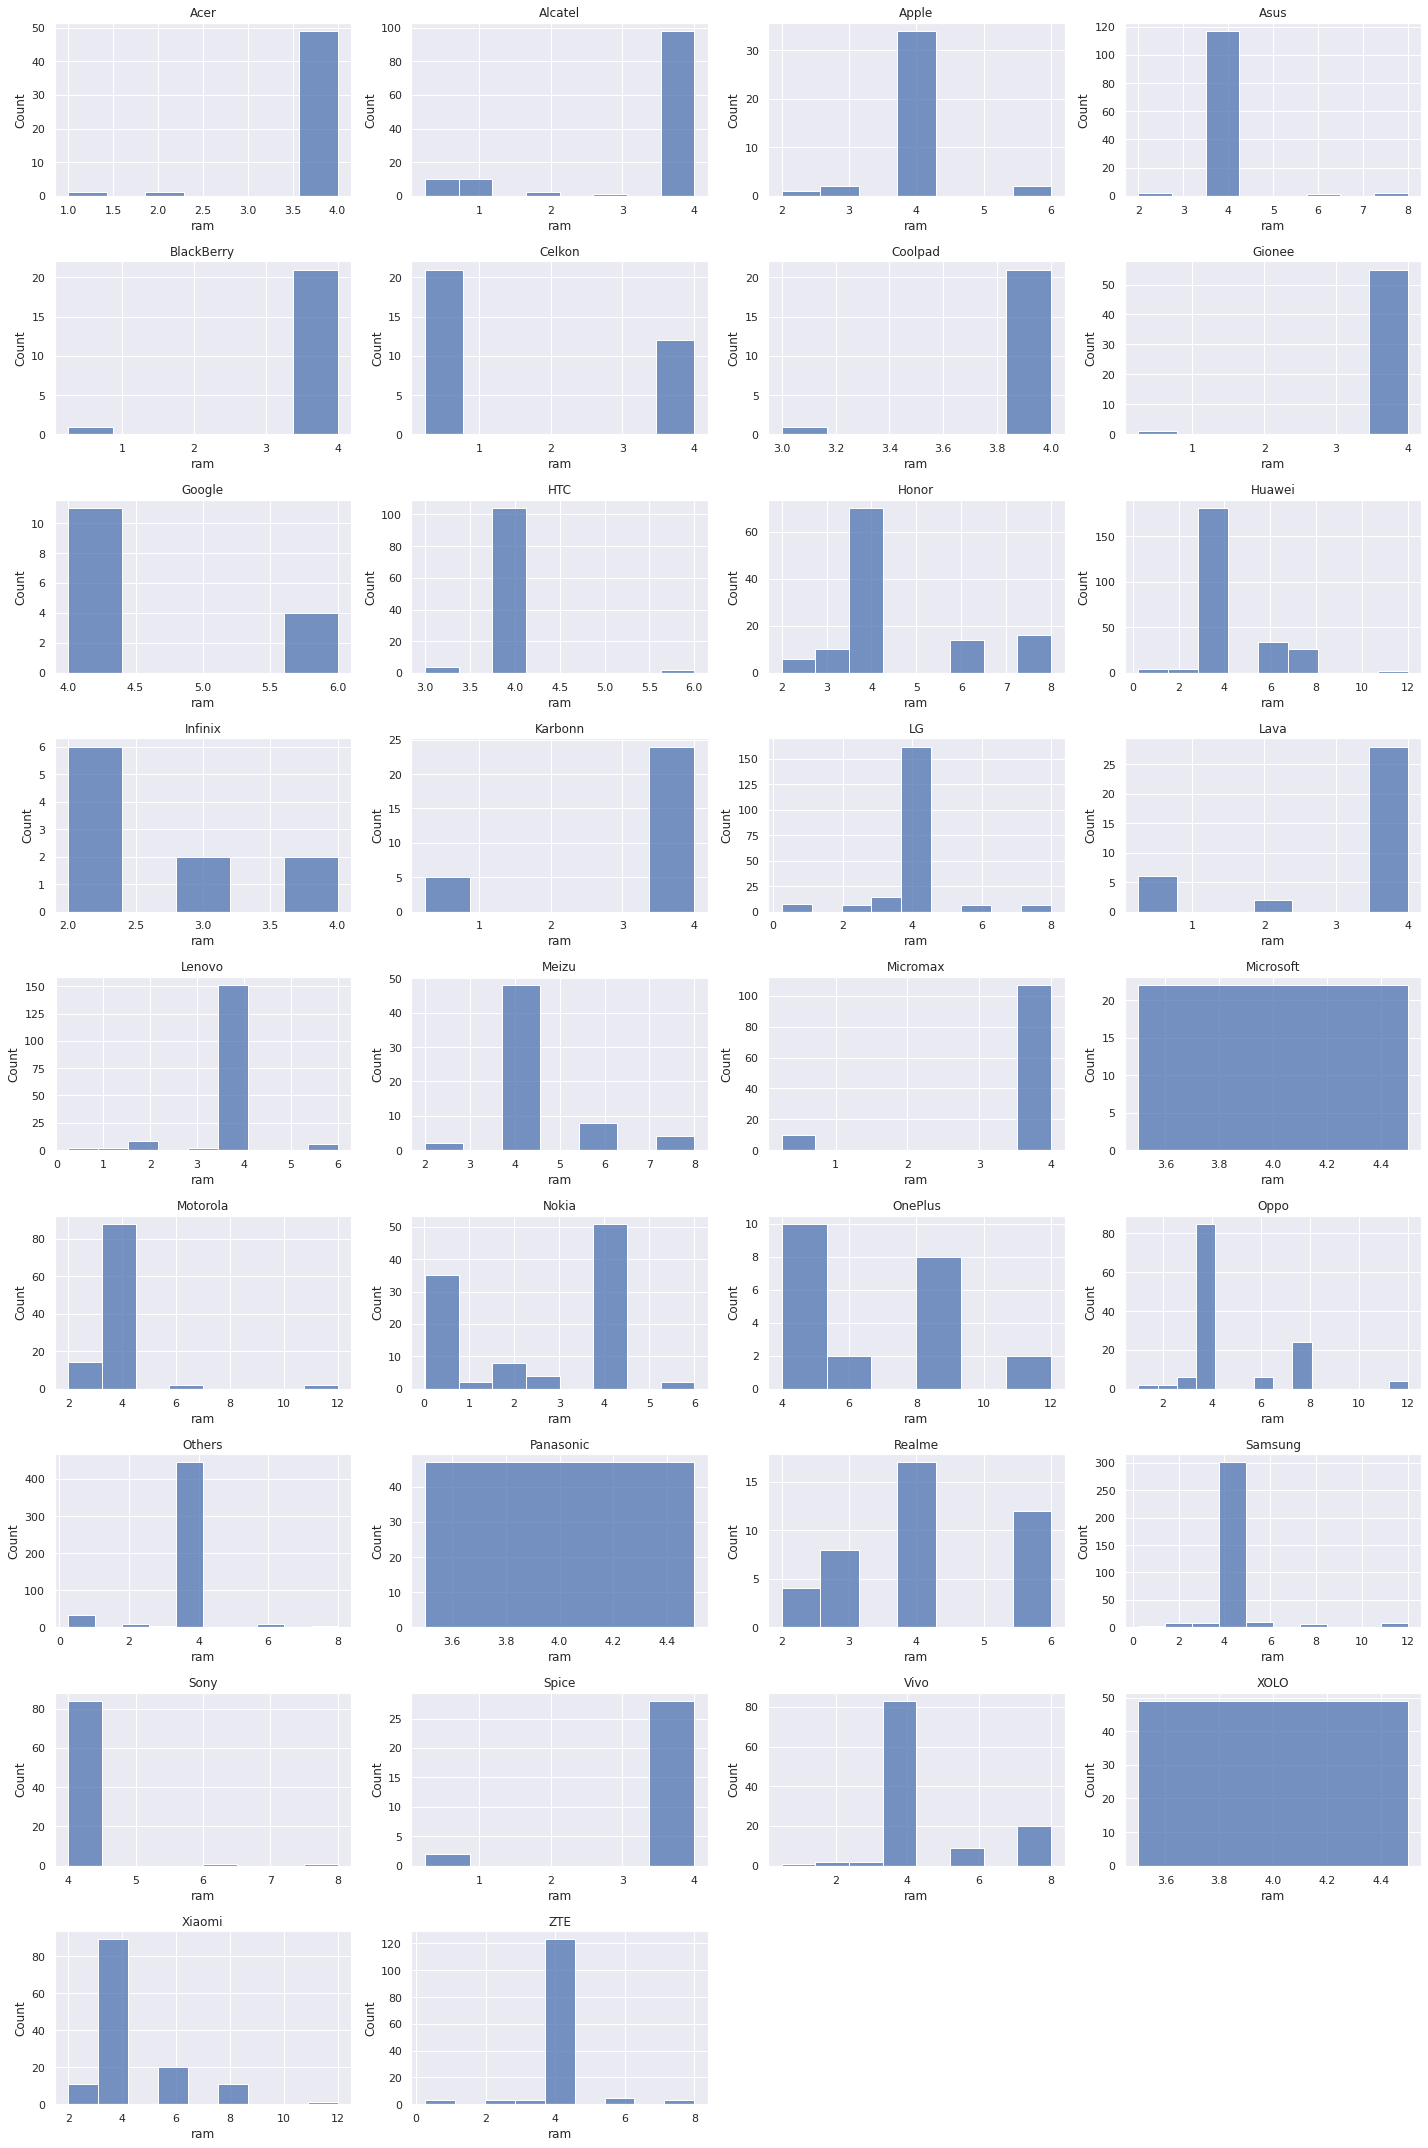

In [ ]:
plt.figure(figsize=(20,30))
rows=1+len(phone['brand_name'].unique())//4

# subplot generating loop
for idx, brand in enumerate(phone['brand_name'].sort_values().unique()):
  plt.subplot(rows,4,idx+1)
  plt.title(brand)
  sns.histplot(data=phone[phone['brand_name']==brand]['ram'])

plt.tight_layout()

What's clear from this breakdown is that every phone brand offers a product with 4GB of RAM on Mobile Market, and it is unmistakably the most common device configuration. For Microsoft, Panasonic, and XOLO, the data set only includes devices with 4GB of RAM. Celkon and Infinix are the only brands for which 4GB of RAM is not the most common configuration. Like most other brands, the most common configuration for OnePlus phones is 4GB of RAM, but unlike the others, OnePlus phones have a very high proportion of offerings with 8GB of RAM.

Next we will look at the weight of devices with high-capacity batteries.

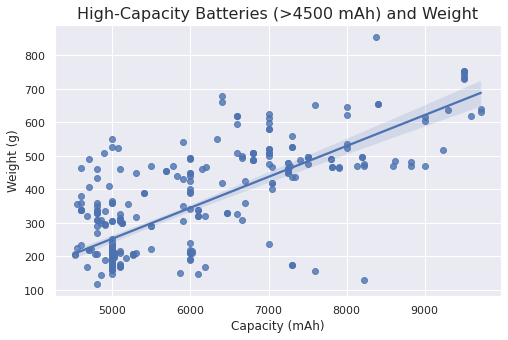

In [ ]:
# collect phones with battery capacity >4500mAh
heavy=phone[phone['battery']>4500]

plt.figure(figsize=(8,5))
plt.title('High-Capacity Batteries (>4500 mAh) and Weight',fontsize=16)
sns.regplot(data=heavy,x='battery',y='weight')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Weight (g)');

There is a positive trend between battery capacity and phone weight. There are, however, a few observations far from the regression line that have high capacity batteries but lower weight. Such devices are generally more valuable since they last longer on a single charge but do not weigh much.

We will now examine several aspects across brands, the first being the distribution of large screen devices.

In [ ]:
# number of phones with screen size >6in = 15.24cm
phone[phone['screen_size']>15.24].shape[0]

1099

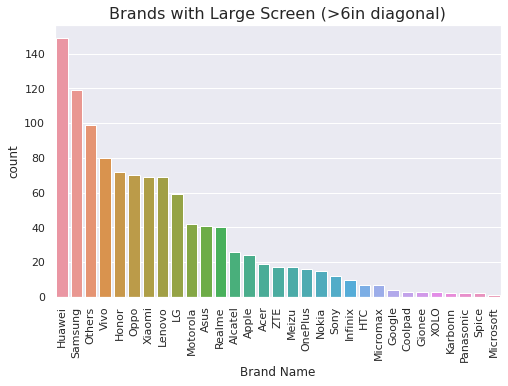

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Brands with Large Screen (>6in diagonal)',fontsize=16)
sns.countplot(data=phone[phone['screen_size']>15.24],
              x='brand_name',
              order=phone[phone['screen_size']>15.24]['brand_name'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Brand Name');

There are 1099 devices in this data set with a screen size greater than 6in diagonally. Huawei and Samsung offer the greatest number of devices with large screens. Panasonic, Spice, and Microsoft offer very few large sceen devices through Mobile Market.

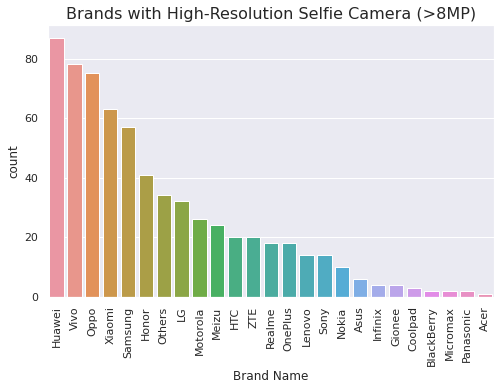

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Brands with High-Resolution Selfie Camera (>8MP)',fontsize=16)
sns.countplot(data=phone[phone['selfie_camera_mp']>8],
              x='brand_name',
              order=phone[phone['selfie_camera_mp']>8]['brand_name'].value_counts().index)
plt.xticks(rotation=90)
plt.xlabel('Brand Name');

Huawei, Vivo, and Oppo offer the greatest number of devices with a high resolution selfie camera, while Micromax, Panasonic, and Acer offer the fewest on Mobile Market.

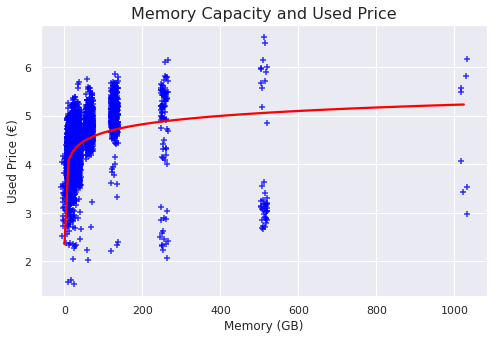

In [ ]:
# logarithmic regression of memory vs used price
plt.figure(figsize=(8,5))
plt.title('Memory Capacity and Used Price',fontsize=16)
sns.regplot(data=phone,
            x='int_memory',
            y='normalized_used_price',
            logx=True,
            x_jitter=10,
            marker='+',
            scatter_kws={'color':'blue'},
            line_kws={'color':'red'},
            ci=False)
plt.xlabel('Memory (GB)')
plt.ylabel('Used Price (€)');

There seems to be a positive trend between device memory capacity and normalized used price. In particular, price appears to be proportional to the logarithm of memory capacity.

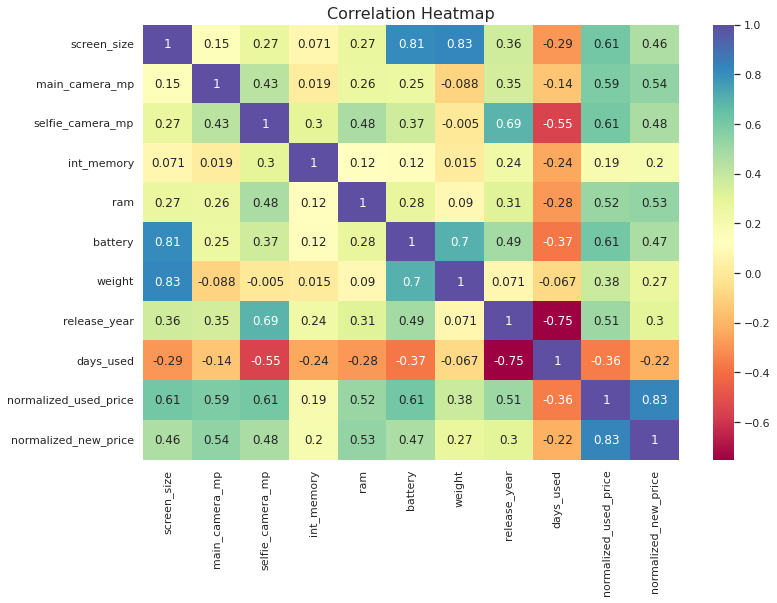

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Correlation Heatmap',fontsize=16)
sns.heatmap(phone.corr(),annot=True,cmap='Spectral');

The correlation matrix highlights several previously unseen relationships. There are some clear ones, like the strong negative correlation between release year and days_used. But we have detected moderately positive correlations between normalized_used_price and the following: screen_size, main_camera_mp, selfie_camera_mp, and battery. We will visualize these, along with the strong positive relationship between battery capacity and weight.

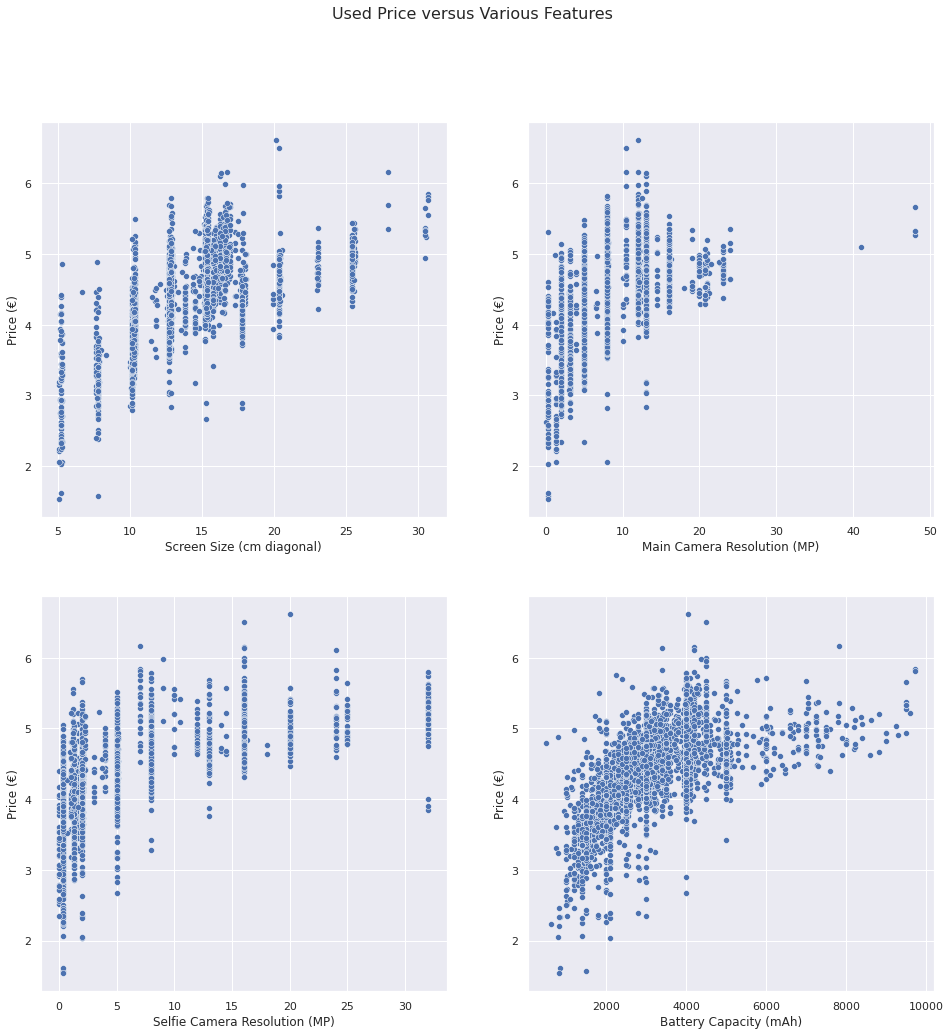

In [ ]:
plt.figure(figsize=(16,16))
plt.suptitle('Used Price versus Various Features', fontsize=16)

# screen_size
plt.subplot(2,2,1)
sns.scatterplot(data=phone,x='screen_size',y='normalized_used_price')
plt.xlabel('Screen Size (cm diagonal)')
plt.ylabel('Price (€)')

# main_camera_mp
plt.subplot(2,2,2)
sns.scatterplot(data=phone,x='main_camera_mp',y='normalized_used_price')
plt.xlabel('Main Camera Resolution (MP)')
plt.ylabel('Price (€)')

# selfie_camera_mp
plt.subplot(2,2,3)
sns.scatterplot(data=phone,x='selfie_camera_mp',y='normalized_used_price')
plt.xlabel('Selfie Camera Resolution (MP)')
plt.ylabel('Price (€)')

# battery
plt.subplot(2,2,4)
sns.scatterplot(data=phone,x='battery',y='normalized_used_price')
plt.xlabel('Battery Capacity (mAh)')
plt.ylabel('Price (€)')

plt.show()

The four scatterplots all illustrate positive correlation but have decidedly different distributions. Note too that some of the relationships have a bit of a curve to the trend, like a logarithmic relationship.

Next, let's look at battery capacity, weight, and screen size of devices on Mobile Market.

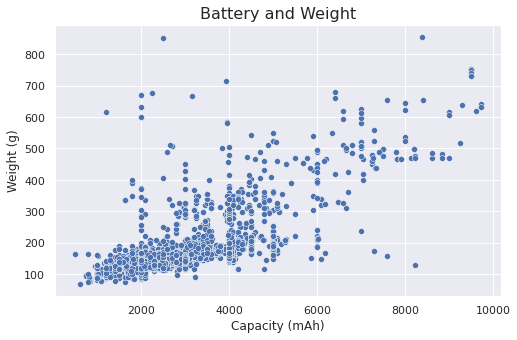

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Battery and Weight',fontsize=16)
sns.scatterplot(data=phone,x='battery',y='weight')
plt.xlabel('Capacity (mAh)')
plt.ylabel('Weight (g)');

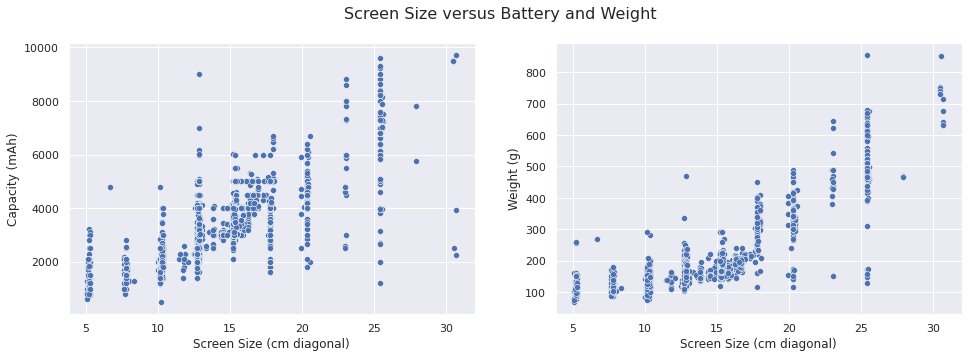

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle('Screen Size versus Battery and Weight',fontsize=16)

# battery
plt.subplot(1,2,1)
sns.scatterplot(data=phone,x='screen_size',y='battery')
plt.xlabel('Screen Size (cm diagonal)')
plt.ylabel('Capacity (mAh)')

# weight
plt.subplot(1,2,2)
sns.scatterplot(data=phone,x='screen_size',y='weight')
plt.xlabel('Screen Size (cm diagonal)')
plt.ylabel('Weight (g)');

While we can observe a positive trend in the first plot, the correlations are more apparent in the latter two (relating screen size to battery and weight).

Consider next days used and new price.

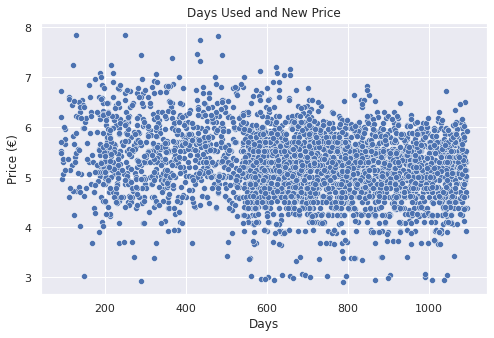

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Days Used and New Price')
sns.scatterplot(data=phone,x='days_used',y='normalized_new_price')
plt.xlabel('Days')
plt.ylabel('Price (€)');

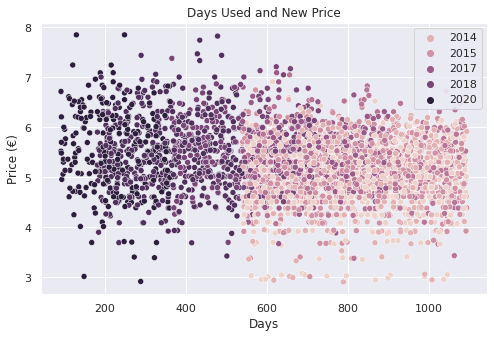

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Days Used and New Price')
sns.scatterplot(data=phone,x='days_used',y='normalized_new_price',hue='release_year')
plt.xlabel('Days')
plt.ylabel('Price (€)')
plt.legend(title='');

On the other hand, there is no apparent trend in the relationship between days_used and normalized_used_price; the scatterplot is just noise. But by adding the release year, we find that phones released less recently are generally used for longer. Not a big surprise!

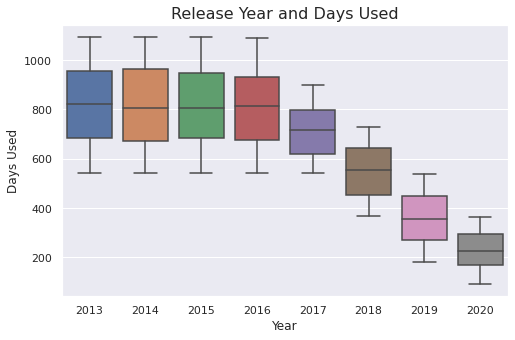

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Release Year and Days Used',fontsize=16)
sns.boxplot(data=phone,x='release_year',y='days_used')
plt.xlabel('Year')
plt.ylabel('Days Used');

Quantifying the relationship between release_year and days_used, we find that the spread of days_used data is similar for release_years up to 2016, and then the data trends negatively (fewer days used) as the phones were more recently released.

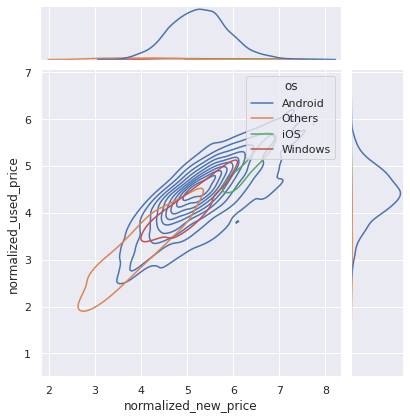

In [ ]:
sns.jointplot(data=phone,
              x='normalized_new_price',
              y='normalized_used_price',
              hue='os',
              kind='kde');

Lastly, looking at the density of new price versus used price, we can identify specifically price brackets broken down by operating system. Devices running Android have the greatest variability in price. On the other hand, iOS is installed on higher priced devices, namely Apple products. The least expensive devices, new or used, run an operating system other than Android, Windows, or iOS.

## Data Preprocessing

### Missing Value Treatment

In [ ]:
phone.isnull().sum()

brand_name                 0
os                         0
screen_size                0
4g                         0
5g                         0
main_camera_mp           179
selfie_camera_mp           2
int_memory                 4
ram                        4
battery                    6
weight                     7
release_year               0
days_used                  0
normalized_used_price      0
normalized_new_price       0
dtype: int64

The feature with the most missing data is main_camera_mp. We will impute the null values with the median camera resolution for the brand of that row in the dataframe.

In [ ]:
# collect medians for main_camera_mp by brand
camera_medians={}
for brand in phone['brand_name'].unique():
  med=phone.loc[phone['brand_name']==brand]['main_camera_mp'].median()
  if np.isnan(med)==False:
    camera_medians[brand]=phone.loc[phone['brand_name']==brand]['main_camera_mp'].median()
  else:
    camera_medians[brand]=0

# impute main_camera_mp with brand median
idx=0
for val in phone['main_camera_mp']:
  if np.isnan(val)==True:
    brand=phone.iloc[idx]['brand_name']
    phone.loc[idx,'main_camera_mp']=camera_medians[brand]
  idx+=1

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [ ]:
phone.isnull().sum()

brand_name               0
os                       0
screen_size              0
4g                       0
5g                       0
main_camera_mp           0
selfie_camera_mp         2
int_memory               4
ram                      4
battery                  6
weight                   7
release_year             0
days_used                0
normalized_used_price    0
normalized_new_price     0
dtype: int64

We will drop rows with the last few null entries, as we will not be losing much data.

In [ ]:
# drop rows with remain few null entries
phone.dropna(axis=0,inplace=True)

In [ ]:
phone.isnull().sum()

brand_name               0
os                       0
screen_size              0
4g                       0
5g                       0
main_camera_mp           0
selfie_camera_mp         0
int_memory               0
ram                      0
battery                  0
weight                   0
release_year             0
days_used                0
normalized_used_price    0
normalized_new_price     0
dtype: int64

### Additional Drops

We can confirm that there are no more null entries. Next, we will also drop any row where both the brand name and the OS have value 'Other', since this combination is too vague to contribute positively to our model.

In [ ]:
print('Number of rows before dropping "Other/Other":',
      phone.shape[0])
print('Number of "Other/Other" rows:',
      phone[(phone['brand_name']=='Others')&(phone['os']=='Others')].shape[0])

Number of rows before dropping "Other/Other": 3432
Number of "Other/Other" rows: 28


In [ ]:
# drop rows with brand_name=Others AND os=Others
for val in phone[(phone['brand_name']=='Others')&(phone['os']=='Others')].index:
  phone.drop(val,axis=0,inplace=True)

In [ ]:
print('Number of rows after dropping "Other/Other":',phone.shape[0])

Number of rows after dropping "Other/Other": 3404


We have dropped all 28 Other/Other rows.

In [ ]:
phone.reset_index(inplace=True,drop=True)

### Data Typing, Feature Engineering, and Outlier Treatment

After five experiments building the linear regression, I have found that the precise release year is not as important as whether the device is older or newer. I can confirm that this change will significantly reduce multicollinearity with negligible effect on the final R-squared. I used the boxplot from the EDA, recalled below, to define the threshold for an old phone.

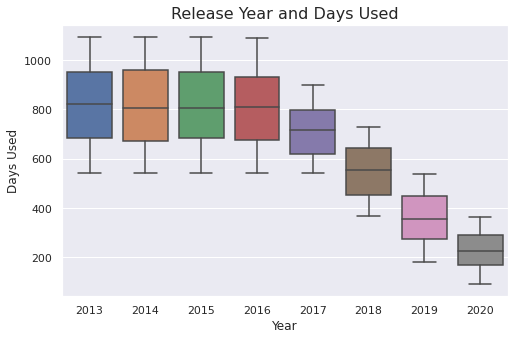

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Release Year and Days Used',fontsize=16)
sns.boxplot(data=phone,x='release_year',y='days_used')
plt.xlabel('Year')
plt.ylabel('Days Used');

In [ ]:
# classify rows
old_phones=[2013,2014,2015,2016]
age=[]
for val in phone['release_year']:
  if val in old_phones:
    age.append('old')
  else:
    age.append('new')

# generate feature
phone['age']=pd.Categorical(age)

In [ ]:
phone=phone.drop(['release_year'],axis=1)

Since over 80% of devices on Mobile Market have 4GB of RAM, we will create a new categorical column. It will have a 1 if the device has 4GB of RAM and a 0 otherwise. This is one way of treating outliers in RAM.

In [ ]:
# classify rows
ram4=[]
for val in phone['ram']:
  if val==4.0:
    ram4.append(1)
  else:
    ram4.append(0)

# generate feature
phone['ram4']=pd.Categorical(ram4)

We will also add a column for the ratio of battery capacity to weight. We can confidently design this feature because battery and weight are strongly correlated. This will have the effect of retaining data about battery and weight while reducing dimension.

In [ ]:
phone['battery_by_weight']=phone['battery']/phone['weight']

I feel we have adequately adressed outliers. Those visible on the boxplots for weight or price are  necessary aspects of the selection process. Our model would be incabaple of predicting price for the breadth of devices on Mobile Market without these data points.

## Second EDA

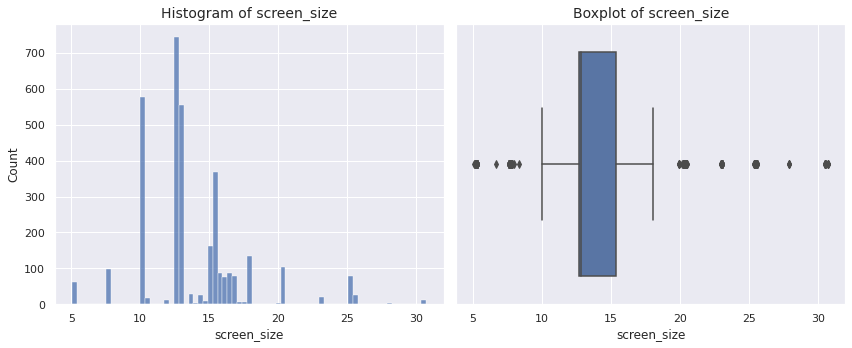

In [ ]:
hist_box(phone,'screen_size')

Screen size remains highly variable after our data transformations.

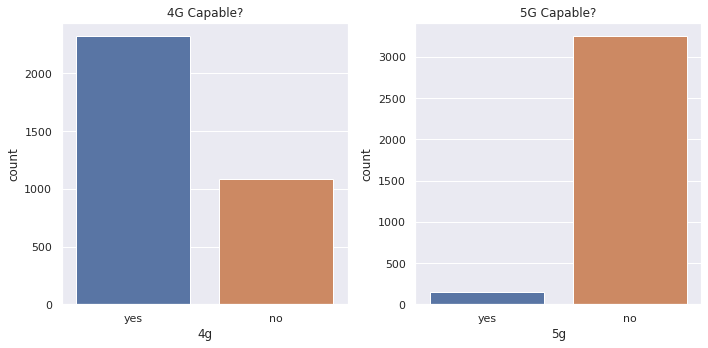

In [ ]:
plt.figure(figsize=(10,5))

# 4g
plt.subplot(1,2,1)
plt.title('4G Capable?')
sns.countplot(data=phone,x='4g',order=('yes','no'))

# 5g
plt.subplot(1,2,2)
plt.title('5G Capable?')
sns.countplot(data=phone,x='5g',order=('yes','no'))

plt.tight_layout()

The ratios of 4g capable phones and 5g capable phone are essentially unchanged from before.

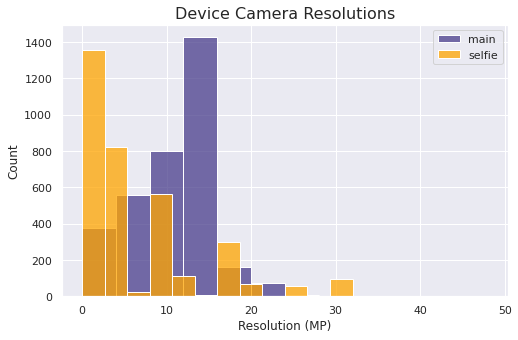

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Device Camera Resolutions',fontsize=16)

# main camera
sns.histplot(phone,x='main_camera_mp',
             bins=12,
             color='darkslateblue',
             label='main')

#selfie camera
sns.histplot(phone,x='selfie_camera_mp',
             bins=12,
             color='orange',
             label='selfie')

plt.xlabel('Resolution (MP)')
plt.legend();

The selfie camera generally has a lower resolution than the main camera. This makes sense, as there is more room in the device frame for a main camera sensor than a selfie camera, since the latter is crowded by the display panel.

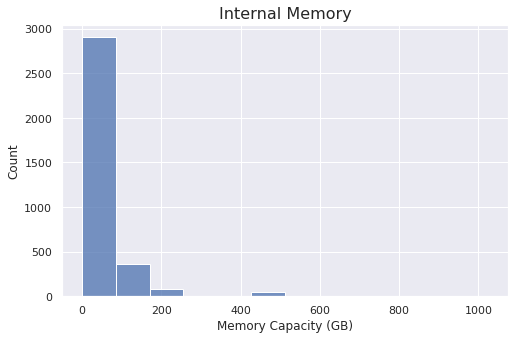

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Internal Memory',fontsize=16)
sns.histplot(phone,x='int_memory',bins=12)
plt.xlabel('Memory Capacity (GB)');

Since memory comes in powers of 2, and less memory is generally cheaper, it tracks that most of the devices have less memory, but that the outliers are far greater than the bulk of the data. The capacity is literally increasing exponentially!

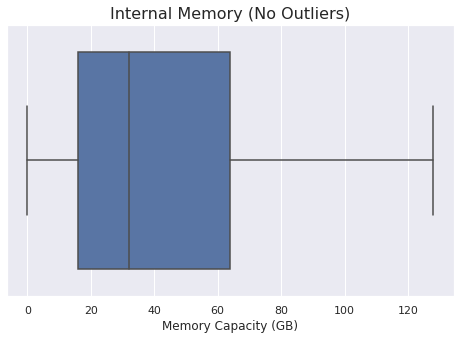

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Internal Memory (No Outliers)',fontsize=16)
sns.boxplot(data=phone,x='int_memory',showfliers=False)
plt.xlabel('Memory Capacity (GB)');

To understand the spread of the majority of our data, consider the boxplot above. Outliers are hidden in this plot, and we see that the middle 50% of the data is between 16GB and 64GB, with a median of 32GB (all powers of 2).

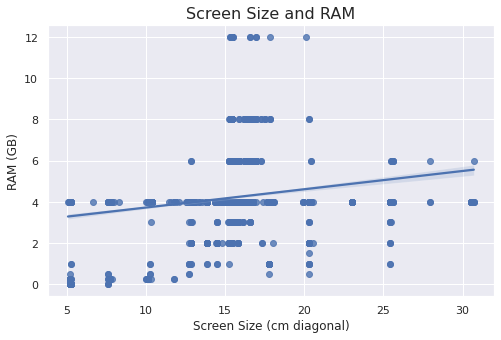

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Screen Size and RAM',fontsize=16)
sns.regplot(data=phone,x='screen_size',y='ram')
plt.xlabel('Screen Size (cm diagonal)')
plt.ylabel('RAM (GB)');

Generally a larger screen, in particular more pixels, requires more RAM for the device to operate smoothly. The trend is visible here, albeit only mildly. 

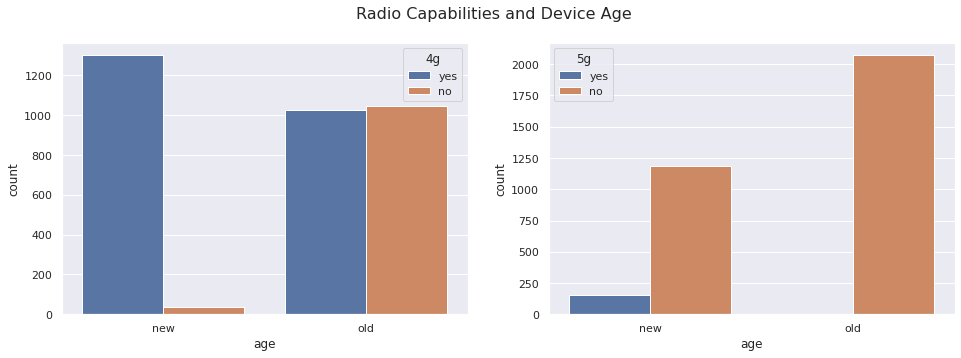

In [ ]:
plt.figure(figsize=(16,5))
plt.suptitle('Radio Capabilities and Device Age',fontsize=16)

plt.subplot(1,2,1)
sns.countplot(data=phone,x='age',hue='4g',hue_order=('yes','no'))

plt.subplot(1,2,2)
sns.countplot(data=phone,x='age',hue='5g',hue_order=('yes','no'));

Here we see that new devices are far more likely to have 4G radios, with almost no new devices lacking. Conversely, about half of old devices lack 4G connectivity.

There are no old devices available on Mobile Market with 5G connectivity, and most of the new devices don't have it either.

## Model Building - Linear Regression

Now we can start preparing our data for modeling. In particular, let's use one hot encoding for our categorical variables.

In [ ]:
phone_dummies=pd.get_dummies(data=phone,drop_first=True)

In [ ]:
# dataframe of independent variables plus constant
X=phone_dummies.drop(['normalized_used_price'],axis=1)
X=sm.add_constant(X)

# response variable series
y=phone_dummies['normalized_used_price']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# split data
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=1)

In [ ]:
# train first model
model=sm.OLS(y_train,X_train)
results=model.fit()

## Model Performance Check

We start by defining functions that will help us assess model performance. The first function generates a table of VIF stats and tests R-squared values for different dropped columns. The second incorporates the first into a data-rich model tuning interface. We will use the standard VIF cutoff of 5, but the function allows different thresholds.

In [ ]:
# import variance inflation factor function
from statsmodels.stats.outliers_influence import variance_inflation_factor

def high_vif_stats(y_data,X_data,vif_cutoff=5):
  '''Summarize VIF and test R-squared
  for VIF > cutoff.'''

  # generate vif table
  vif=pd.Series([variance_inflation_factor(X_data.values,i) for i in range(X_data.shape[1])],
               index=X_data.columns).sort_values(ascending=False)
  print('Variance Inflation Factors')
  print(vif)

  # collect high vif columns (omit constant col)
  high_vif_col=[]
  for idx, val in vif.drop(['const'],axis=0).items():
    if val>vif_cutoff:
      high_vif_col.append(idx)
  if len(high_vif_col)==0:
    print('\nThere are no features with VIF greater than',vif_cutoff)
    return

  # create dataframe with original R-squared
  results=sm.OLS(y_data,X_data).fit()
  rsq_comp=pd.DataFrame({'R-squared':np.round(results.rsquared,3),
                        'Adj. R-squared':np.round(results.rsquared_adj,3)},
                        index=['Before'])

  # tabulate R-square and adj. R-squared without high vif cols
  for col in high_vif_col:
    res=sm.OLS(y_data,X_data.drop([col],axis=1)).fit()
    df=pd.DataFrame({'R-squared':np.round(res.rsquared,3),
                    'Adj. R-squared':np.round(res.rsquared_adj,3)},
                    index=['Without '+col])
    rsq_comp=pd.concat([rsq_comp,df],axis=0)

  # print table of R-squared values
  title='R-squared for data with dropped high-VIF columns'
  print('='*len(title))
  print(title)
  print(rsq_comp)

  return

def model_tuning(y_data,X_data,*,threshold=5,hide_vif=False):
  '''Presents summary of OLS model
  and multicollinearity check given
  VIF threshold (default=5).'''

  # generate model
  model=sm.OLS(y_data,X_data).fit()
  
  # print model statistics and high VIF table
  print(model.summary())
  if hide_vif==False:
    print('\n\n')
    high_vif_stats(y_data,X_data,vif_cutoff=threshold)
  return model

# print series without truncating
pd.set_option('display.max_rows',None)

In [ ]:
model_tuning(y_train,X_train)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.842
Model:                               OLS   Adj. R-squared:                  0.838
Method:                    Least Squares   F-statistic:                     247.8
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:01   Log-Likelihood:                 131.16
No. Observations:                   2382   AIC:                            -160.3
Df Residuals:                       2331   BIC:                             134.2
Df Model:                             50                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


We have seen that weight is highly positively correlated with screen size and battery capacity. Since it's VIF is the highest, we will drop it.

In [ ]:
# drop weight column
X_train=X_train.drop(['weight'],axis=1)

# keep track of dropped features
dropped_cols=['weight']

In [ ]:
model_tuning(y_train,X_train)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     248.7
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:02   Log-Likelihood:                 114.04
No. Observations:                   2382   AIC:                            -128.1
Df Residuals:                       2332   BIC:                             160.7
Df Model:                             49                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


There's an interesting argument to be made that we can drop either brand_name_Apple or os_iOS. While both belong to categorical variables, these two features must be highly correlated: The only brand running iOS is Apple and the only OS on Apple devices is iOS. In other words, there is indeed redundancy in including both features. While brand_name_Apple has higher VIF, os_iOS has an incredibly high p-value. In addition, after building out the subsequent regression several times, I have determined that losing OS data will not be detrimental to our model (as the p-value will remain high regardless).

In [ ]:
# drop
X_train=X_train.drop(['os_iOS'],axis=1)

# add col to dropped_cols list
dropped_cols.append('os_iOS')

In [ ]:
model_tuning(y_train,X_train)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     254.0
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:03   Log-Likelihood:                 114.04
No. Observations:                   2382   AIC:                            -130.1
Df Residuals:                       2333   BIC:                             152.9
Df Model:                             48                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


It seems that brand_name_Others is more complicating than elucidating. It may very well be too imprecise to be beneficial for our model. Let's drop it knowing that the R-squared value will not decrease. 

In [ ]:
# drop brand_name_Others
X_train=X_train.drop(['brand_name_Others'],axis=1)

# add to dropped_col
dropped_cols.append('brand_name_Others')

In [ ]:
model_tuning(y_train,X_train)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     259.5
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:04   Log-Likelihood:                 113.91
No. Observations:                   2382   AIC:                            -131.8
Df Residuals:                       2334   BIC:                             145.4
Df Model:                             47                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Our R-squared did not change and brand_name_Samsung no longer has high VIF.

Since we have both battery_by_weight and screen_size predicting battery, we can confidently remove the latter, as it has high VIF.

In [ ]:
# drop
X_train=X_train.drop(['battery'],axis=1)

# append to list
dropped_cols.append('battery')

In [ ]:
model_tuning(y_train,X_train)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.835
Method:                    Least Squares   F-statistic:                     263.8
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:05   Log-Likelihood:                 108.36
No. Observations:                   2382   AIC:                            -122.7
Df Residuals:                       2335   BIC:                             148.7
Df Model:                             46                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


There was no effect on R-squared, we have eliminated all high VIF features.

Next we'll look at p-values, assuming a 5% level of significance. The p-values for os_Others and os_Windows are both high, indicating that operating system is generally not a good predictor of used price. We will drop all os features.

In [ ]:
# drop
X_train=X_train.drop(['os_Others','os_Windows'],axis=1)

# append
dropped_cols.append('os_Others')
dropped_cols.append('os_Windows')

In [ ]:
model_tuning(y_train,X_train,hide_vif=True)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     275.9
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:07   Log-Likelihood:                 108.01
No. Observations:                   2382   AIC:                            -126.0
Df Residuals:                       2337   BIC:                             133.9
Df Model:                             44                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Dropping os_Others and os_Windows has had no impact on the model's R-squared.

With a p-value of 0.543, days_used is certainly not lending any predictive insight to our model. Let's drop it.

In [ ]:
# drop
X_train=X_train.drop(['days_used'],axis=1)

# append
dropped_cols.append('days_used')

In [ ]:
model_tuning(y_train,X_train,hide_vif=True)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     282.4
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:07   Log-Likelihood:                 107.82
No. Observations:                   2382   AIC:                            -127.6
Df Residuals:                       2338   BIC:                             126.5
Df Model:                             43                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Dropping days_used had no impact on R-squared either.

Despite high p-values, I do not believe we can drop only some of the brand_name columns. This is because dropping only part of a categorical variable will negatively impact interpretability of the model. Thus, the only other features with high p-values are 5g_yes and ram4_1. The former records whether the device has 5G connectivity, which is apparently not a good predictor for price, especially as compared to 4G connectivity. The latter is a feature I made in an attempt to bin observations for RAM; it appears to not benefit the model.

We will still only drop one column at a time to record the effect on the R-squared value.

In [ ]:
# drop
X_train=X_train.drop(['5g_yes'],axis=1)

# append
dropped_cols.append('5g_yes')

In [ ]:
model_tuning(y_train,X_train,hide_vif=True)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.839
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     289.2
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:07   Log-Likelihood:                 107.60
No. Observations:                   2382   AIC:                            -129.2
Df Residuals:                       2339   BIC:                             119.2
Df Model:                             42                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


Dropping 5g_yes had no effect on the R-squared. What's more, the p-value for ram4_1 actually went up, further confirming our hypothesis that this feature is not necessary.

In [ ]:
# drop
X_train=X_train.drop(['ram4_1'],axis=1)

# append
dropped_cols.append('ram4_1')

In [ ]:
model=model_tuning(y_train,X_train,hide_vif=True)

                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.838
Model:                               OLS   Adj. R-squared:                  0.836
Method:                    Least Squares   F-statistic:                     296.1
Date:                   Sat, 08 Oct 2022   Prob (F-statistic):               0.00
Time:                           04:45:08   Log-Likelihood:                 106.85
No. Observations:                   2382   AIC:                            -129.7
Df Residuals:                       2340   BIC:                             112.9
Df Model:                             41                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


R-squared only decreased by 0.001 after dropping ram4_1. Outside of the brand_name columns, there are no p-values greater than 0.05. With that, we have a model that explains 83.8% of the variance in used price!

## Checking Linear Regression Assumptions

In [ ]:
# tabulate model performance
model_perf=pd.DataFrame.from_dict({'Actual':y_train.values,
                                   'Fitted':model.fittedvalues.values,
                                   'Residuals':model.resid.values})

In [ ]:
model_perf.head()

,Actual,Fitted,Residuals
0,5.169518,5.033365,0.136153
1,4.284276,4.485839,-0.201563
2,4.955757,4.771354,0.184403
3,4.460607,4.403883,0.056724
4,4.005695,4.063245,-0.057549


### Linearity and Independence

If our data really does exhibit a linear relationship, then there should be no pattern in the plot of fitted values versus residuals.

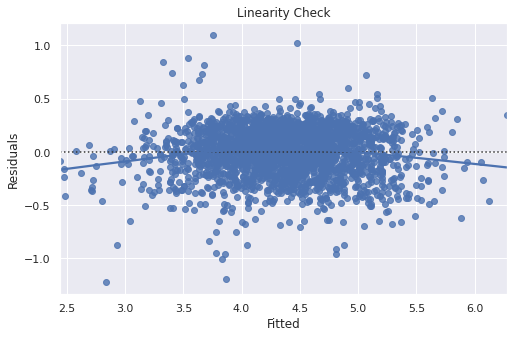

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Linearity Check')
sns.residplot(data=model_perf,x='Fitted',y='Residuals',lowess=True);

There is at worst a weak trend apparent here, but the data is essentially noise. This affirms that there is a linear relationship between our inputs and the response variable, normalized_used_price.

In addition, the plot confirms the independence of residuals, since there is no regularity or pattern in the residuals.

### Normality

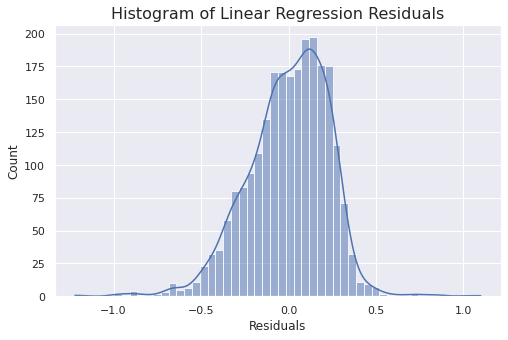

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Histogram of Linear Regression Residuals',fontsize=16)
sns.histplot(data=model_perf,x='Residuals',kde=True);

All told, this distribution is reasonably normal. The only issues seem to be on the tails. Further evidence in favor of normality can be obtained by studying the QQ plot.

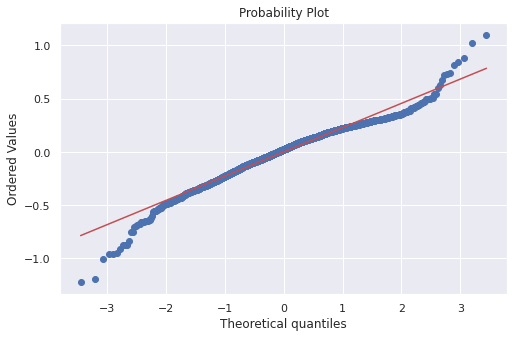

In [ ]:
# import extra library for QQ plot
import pylab

plt.figure(figsize=(8,5))
stats.probplot(model_perf['Residuals'],dist='norm',plot=pylab);

Again, save for the tails, we find that the distribution is close to normal. Recall that a normal distribution will follow the diagonal of a QQ plot.

But let's go further by running a Shapiro-Wilk test at a 5% level of significance. We make the following hypotheses:
$$H_0: \text{Residuals are normally distributed.}$$
$$H_a: \text{Residuals are NOT normally distributed.}$$

In [ ]:
test_stat,p_val=stats.shapiro(model_perf['Residuals'])
print('The p-value of the Shapiro-Wilk test for residuals is:',p_val)

The p-value of the Shapiro-Wilk test for residuals is: 6.636463188267622e-21


Unfortunately, the Shapiro-Wilk test implies the distribution of residuals is almost certainly not normal. Hence, while the distribution is not *technically* normal, it is approximately normal, as shown in the two plots. Put another way, we can use it for our purposes so long as we keep in mind its limitations and reliability.

### Homoscedasticity

Homoscedasticity concerns the variance of residuals. We require that the variance of residuals remain consistent throughout the data.

We will run the Goldfeld-Quandt test, a hypothesis test for homoscedasticity. We make the assumption that the residuals are homoscedastic, with the alternative being that they are heteroscedastic.
$$H_0: \text{Residuals are homoscedastic.}$$
$$H_a: \text{Residuals are heteroscedastic.}$$
We will assume a 5% level of significance.

In [ ]:
# homoscedasticity test
test=statsmodels.stats.diagnostic.het_goldfeldquandt(model_perf['Residuals'],X_train)
print('The p-value for the Goldfeld-Quandt test is:',test[1])

The p-value for the Goldfeld-Quandt test is: 0.24735380493522216


Since the p-value is greater than 0.05, we can safely conclude that the residuals are homoscedastic.

## Final Model

In [ ]:
# drop required columns from test data
X_test=X_test.drop(dropped_cols,axis=1)

In [ ]:
# generate predicted y values with model
y_predicted=model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
print('The RMSE on the training data is:',
      np.sqrt(mean_squared_error(y_train,model_perf['Fitted'])))

The RMSE on the training data is: 0.23135627303854692


In [ ]:
print('The RMSE on the test data is:',
      np.sqrt(mean_squared_error(y_test,y_predicted)))

The RMSE on the test data is: 0.2344360049678886


The RMSE is low for both the training data and the test data. What's more, the numbers are almost equal, which implies overfitting is not an issue for our model.

In [ ]:
print('The mean absolute error for the training data is:',
      mean_absolute_error(y_train,model_perf['Fitted']))

The mean absolute error for the training data is: 0.18154048705559045


In [ ]:
print('The mean absolute error for the test data is:',
      mean_absolute_error(y_test,y_predicted))

The mean absolute error for the test data is: 0.18160092038083928


Again, the values for the training data and the test data are quite close. The low mean absolute error for the test data indicates that the average error commited by the model in predicting normalized_used_price is only 0.18€.

We conclude that this is a strong model that performs well on out-of-sample data.

## Actionable Insights and Recommendations 

For reference, the model parameters are listed below. We can use these to draw business conclusions.

In [ ]:
model.params

const                    1.300184
screen_size              0.042756
main_camera_mp           0.020663
selfie_camera_mp         0.013775
int_memory               0.000137
ram                      0.014610
normalized_new_price     0.418463
battery_by_weight       -0.004308
brand_name_Alcatel      -0.017111
brand_name_Apple        -0.020045
brand_name_Asus          0.032903
brand_name_BlackBerry    0.082250
brand_name_Celkon       -0.291263
brand_name_Coolpad       0.008939
brand_name_Gionee        0.012789
brand_name_Google        0.043397
brand_name_HTC          -0.007726
brand_name_Honor         0.009408
brand_name_Huawei       -0.024759
brand_name_Infinix       0.324816
brand_name_Karbonn       0.008970
brand_name_LG           -0.035735
brand_name_Lava         -0.007912
brand_name_Lenovo        0.023106
brand_name_Meizu        -0.023462
brand_name_Micromax     -0.021357
brand_name_Microsoft     0.024526
brand_name_Motorola     -0.066186
brand_name_Nokia         0.059966
brand_name_One

Model Insights
* We saw a strong positive correlation between normalized_new_price and normalized_used_price in the correlation heatmap. This is reflected in the linear model parameters, which shows that for every 1€ increase in new price, there is an increase in the used price of 0.418€.
* Every centimeter increase in screen size adds 0.043€ to the used price.
* Main camera resolution has a greater impact on used price than selfie camera resolution.
* Devices released before 2017 will sell for less on Mobile Market.
* 4G connectivity contributes positively to the price, adding 0.069€.
* Every GB increase in internal memory has less impact on price than every GB increase in RAM. This is because phones have much more internal memory than RAM, so each additional GB of RAM is a greater percentage increase in the total amount. (Going from 2GB to 3GB of RAM is a 50% increase, whereas going from 64GB to 65GB of internal memory is only a 1.6% increase. There is a far wider range of values for internal memory than RAM.)
* Infinix brand devices command a higher used price, adding 0.325€ on top of the total generated by the device specifications.
* On the other hand, the Celkon brand has a lower used price, taking away 0.291€ from the total generated by the device specifications.

Mobile Market Recommendations
* The best predictor of used price is the new price of the same device. If Mobile Market wanted to drive higher prices, they should focus on re-selling phones with higher prices when new.
* Devices with larger screens sell for a higher price too, so concentrating on large-format smart phones and tablets, which have become more popular in recent years, would help Mobile Market garner higher prices.
* Premium brands seem to sell for *less* used. This is likely because premium devices are updated yearly, with older models becoming outdated trends. With all the new features introduced each year, oulder models are immediately less desirable. Mobile Market could distinguish itself in the market by offering premium phones for less, as brands like Apple, Huawei, Motorola, and Samsung actually reduce the price of the device.
* Mobile Market could also boost the price of devices by offering phones with larger screens, higher resolution cameras, and lots of RAM.

___